Deleting all stuff not essential for vae integration (sine experiments, etc)

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib
import torchvision

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
matplotlib.use('Agg')
"""
%load_ext autoreload
%autoreload 2
%matplotlib inline"""

/usr/lib/python3/dist-packages/matplotlib/__init__.py:1403: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


'\n%load_ext autoreload\n%autoreload 2\n%matplotlib inline'

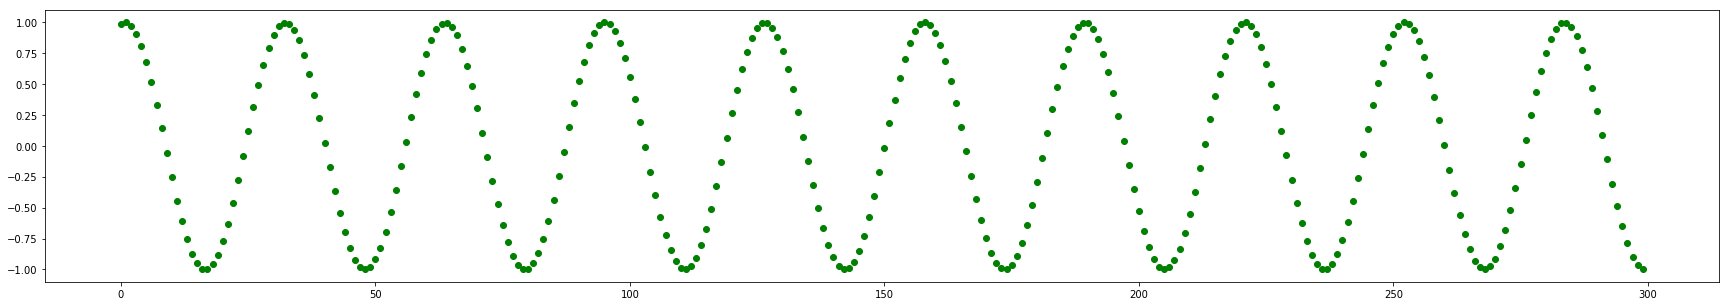

(5000, 300)

In [2]:
# Generate training data
np.random.seed(23)

T = 5

# these are set to one more than necessary. We set them again later.
L = 300 # to create X and y, need to pad by one
N = 5000 # when zipping together, lose one.

noise = np.random.uniform(-0.1, 0.1, (N, L)).astype(np.float32)

x = np.empty((N, L), 'float32')
x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
data = np.sin(x / 1.0 / T).astype('float64') #+ noise

plt.figure(figsize=(30,5))
plt.plot(np.arange(L), data[0], 'go', alpha=1, markerfacecolor='green')
plt.show()

data.shape

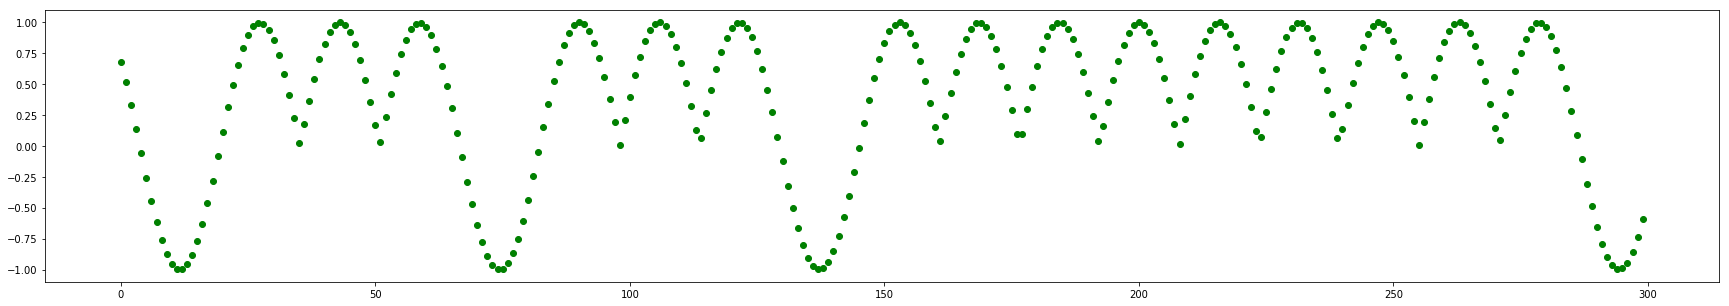

(5000, 300)

In [3]:
# create new dataset by randomly inverting waves to create challenge only MDN can handle
rand_data = []
for ii in range(len(data)):
    seq = data[ii]
    dd = [seq[0]]
    invert = False
    for i in range(1, len(data[0])):
        d = seq[i]; d_prev = seq[i-1]
        if d < 0 and d_prev > 0 and np.random.random() > .50: invert = True
        elif d > 0 and d_prev < 0: invert = False
        if invert: dd.append(seq[i]*-1)
        else: dd.append(seq[i])
    rand_data.append(dd)
plt.figure(figsize=(30,5))
plt.plot(np.arange(L), rand_data[1], 'go', alpha=1, markerfacecolor='green')
plt.show()

# overwriting original data
data = np.array(rand_data); data.shape

In [4]:
N-=1; L-=1

In [0]:
# zip arrays into arrays of two dims each.
data_mult_dim = []
for i in range(N): 
    data_mult_dim.append([list(a) for a in zip(data[i], data[i+1])])
data_mult_dim = torch.Tensor(np.array(data_mult_dim)); 

In [5]:

data_mult_dim = torch.load('z_seq.pt')

data_mult_dim.shape # bs, seq len, num latents

torch.Size([3000, 222, 100])

In [6]:
# Create dataloader

bs = 10
dataloader = DataLoader(data_mult_dim, batch_size=bs, shuffle=True) 

In [7]:
# Model. MUST MANUALLY CHANGE N_IN to reflect size of z

N_IN = 100; N_HIDDEN = 512; N_GAUSSIANS = 5; N_LSTM_LAYERS = 1

class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        
        self.lstm = nn.LSTM(N_IN, N_HIDDEN, num_layers=N_LSTM_LAYERS) # this outputs the hidden state, which must be run through linear for result.
        
        self.linear = nn.Linear(N_HIDDEN, N_IN) # mdn doesn't use this
        
        self.z_pi = nn.Linear(N_HIDDEN, N_GAUSSIANS*N_IN)
        self.z_sigma = nn.Linear(N_HIDDEN, N_GAUSSIANS*N_IN)
        self.z_mu = nn.Linear(N_HIDDEN, N_GAUSSIANS*N_IN)

    def init_hidden(self, n_seqs):
        # Before we've done anything, we dont have any hidden state.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        self.hidden = (torch.zeros(N_LSTM_LAYERS, n_seqs, N_HIDDEN).cuda(), # for cell, there are no layers. for lstm, using single layer
                torch.zeros(N_LSTM_LAYERS, n_seqs, N_HIDDEN).cuda())

    def forward(self, x): 
        # "out" will give you access to all hidden states in the sequence
        # "hidden" will allow you to continue the sequence and backpropagate,
        # by passing it as an argument  to the lstm at a later time
        
        # understand these mechanics more.
        out, self.hidden = self.lstm(x, self.hidden) # i was confusing what was h_t, c_t. Do more research on this
        
        pred = self.linear(out)
        
        # also predicting distributions to draw from for MDN
        pi = self.z_pi(out).view(x.size(0), x.size(1), N_GAUSSIANS, N_IN) # output of linear is all mushed together. separating out.
        pi = F.softmax(pi, dim=2)
        #pi = pi / TEMPERATURE
        
        sigma = self.z_sigma(out).view(x.size(0), x.size(1), N_GAUSSIANS, N_IN)
        sigma = torch.exp(sigma)
        #sigma = sigma * (TEMPERATURE ** 0.5)
        
        mu = self.z_mu(out).view(x.size(0), x.size(1), N_GAUSSIANS, N_IN)
        
        return pred, {"pi":pi, "sigma":sigma, "mu":mu}

In [14]:
# init model

lstm = LSTM(); 

if torch.cuda.is_available():
    print("cuda available")
    lstm.cuda()
    
#from ctallec world models implementation
optimizer = optim.RMSprop(lstm.parameters(), lr=1e-3, alpha=.9) #optimizer = optim.SGD(lstm.parameters(), lr=0.001)

cuda available


In [ ]:
# train

N_SAMPLES = 5 #only used for viz, not important for training

for epoch in range(50): # for each epoch
    print("Epoch", epoch)
    for i, batch in enumerate(dataloader): # for each batch
        
        X = batch[:,:-1,:]; y = batch[:,1:,:] # staggering by one
        
        L = X.size(1)
        
        N_SEQS = X.size(0) # allowing flexibility with batch size
        
        lstm.init_hidden(N_SEQS) # always start sequence with fresh hidden state

        X = torch.Tensor(X).transpose(0,1).view(L, N_SEQS, N_IN).cuda()
        # when transitioning to lstm from cell, switching axes all around. insert another dimension L at beginning. Can
        # also use lstm to do one-by-one, in that case L=1.

        pred_next, mdn_coefs = lstm(X) # feeding in one at a time from each sequence, marching side by side
        actual_next = torch.Tensor(y).transpose(0, 1).view(L, N_SEQS, N_IN).cuda() # reshape target to match lstm output

        #No MDN
        #loss = (actual_next - pred_next).pow(2).sum()

        #MDN

        sequence_loss = mdn_loss_function(mdn_coefs["pi"], 
                     mdn_coefs["sigma"], 
                     mdn_coefs["mu"], 
                     actual_next.view(L, N_SEQS, 1, N_IN)) # mdn params are split out, so we're padding a bit to match them up

        lstm.zero_grad()
        sequence_loss.backward()
        nn.utils.clip_grad_norm(lstm.parameters(), 1) # Yes! this halts the explosion
        optimizer.step()
        if i % 100 == 0: print("loss: ", sequence_loss.item())
        """
        if epoch % 100 == 0:

            plt.figure(figsize=(30,5))
            # actual
            plt.plot(np.arange(L), [e[0] for e in x[:,0,:].squeeze(1).detach().numpy()], 'go', alpha=1, markerfacecolor='red')
            plt.plot(np.arange(L), [e[1] for e in x[:,0,:].squeeze(1).detach().numpy()], 'go', alpha=1, markerfacecolor='red')

            # no MDN

            plt.plot(np.arange(L), pred_next[:,0,:].squeeze(1).detach().numpy(), 'go', alpha=0.2, markerfacecolor='green') 

            # MDN

            plt.show()"""
        
torch.save(lstm.state_dict(), 'lstm.torch')

Epoch 0
loss:  -1.2942588329315186


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:36: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


loss:  -1.3777239322662354
loss:  -1.621042013168335
Epoch 1
loss:  -1.689603567123413
loss:  -1.5303171873092651
loss:  -1.6525366306304932
Epoch 2
loss:  -1.6017112731933594
loss:  -1.7151700258255005
loss:  -1.4801043272018433
Epoch 3
loss:  -1.8307535648345947
loss:  -1.7660441398620605
loss:  -1.4144034385681152
Epoch 4
loss:  -1.7073323726654053
loss:  -1.685215711593628
loss:  -1.6774238348007202
Epoch 5
loss:  -1.6586859226226807
loss:  -1.6756527423858643
loss:  -1.6092153787612915
Epoch 6
loss:  -1.5159164667129517
loss:  -1.6036224365234375
loss:  -1.8464909791946411
Epoch 7
loss:  -1.7313920259475708
loss:  -1.6575725078582764
loss:  -1.4756097793579102
Epoch 8
loss:  -1.7936639785766602
loss:  -1.698770523071289
loss:  -1.7599502801895142
Epoch 9
loss:  -1.714054822921753
loss:  -1.531107783317566


In [16]:
for p in lstm.parameters():
    print(p)

Parameter containing:
tensor([[ 0.1019,  0.0174,  0.0695,  ..., -0.0529,  0.0221,  0.1059],
        [ 0.0816,  0.0439, -0.0935,  ..., -0.0410,  0.0099, -0.0354],
        [ 0.0994, -0.0341,  0.2515,  ..., -0.1312,  0.1053,  0.0661],
        ...,
        [-0.0127,  0.0501,  0.0640,  ..., -0.0972,  0.0122,  0.0759],
        [-0.0618, -0.1005,  0.0239,  ..., -0.0842,  0.1130, -0.0311],
        [ 0.1164,  0.0518,  0.1662,  ..., -0.0855,  0.1730, -0.0856]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[ 0.1225, -0.3612, -0.2206,  ..., -0.1556, -0.2550,  0.0673],
        [ 0.0426,  0.1114, -0.4133,  ...,  0.3697,  0.1846,  0.0556],
        [ 0.0062,  0.0288,  0.0539,  ..., -0.0791, -0.2740, -0.1107],
        ...,
        [ 0.0859,  0.0289,  0.0169,  ..., -0.1074,  0.0329, -0.0670],
        [ 0.0082, -0.1949, -0.2420,  ...,  0.0731,  0.1442, -0.1784],
        [-0.0427,  0.0400,  0.0438,  ...,  0.1396,  0.0513, -0.2457]],
       device='cuda:0', requires_grad=True)


In [17]:
torch.save(lstm.state_dict(), 'lstm.torch')

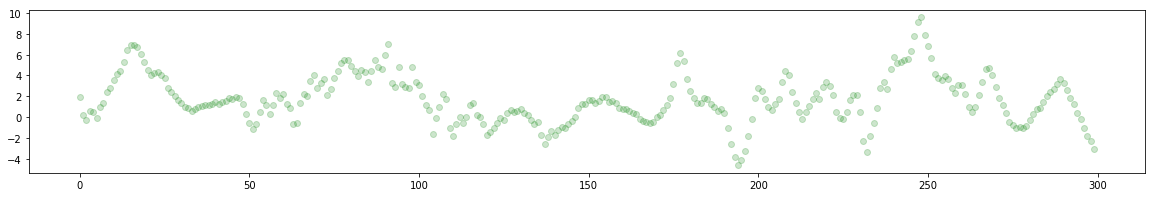

In [18]:
# Predicting the future. Feeding in a single item from a single seq.

N_SAMPLES = 10; N_GEN = 300

with torch.no_grad():
    
    lstm.init_hidden(1) # always start sequence with fresh hidden state
    sample_seq_pred = []

    x = data_mult_dim[0][0] # init w random value from original dataset

    sample_ix = 1
    gen_z = []
    for i in range(N_GEN): 

        x = x.view(1, 1, N_IN).cuda() # padding to fit into lstm expectation
        pred_next, mdn_coefs = lstm(x) # feeding in one at a time from each sequence, marching side by side

        # non mdn
        #sample_seq_pred.append(pred_next[0][0].detach().numpy())

        # mdn

        # Akward setup for generation. First, splitting a pred sample for each dim bc that's how
        # old sampling apparatus works, then zipping them back together bc we need to feed them back into 
        # the model. Should 1) fix sampling apparatus to take in what we've got. 2) allow model to init 
        # hidden state with variable N bc when generating there's no need to output pred for EACH seq. 
        next_z = []
        for i in range(N_IN):
            # splitting mdn coefs into two sets, one for each dim, to feed into old sampling apparatus
            pi_0 = mdn_coefs["pi"][0,0,:,i]; # first item in first seq, take all gauss and first dim, then second dim.
            mu_0 = mdn_coefs["mu"][0,0,:,i]; 
            sigma_0 = mdn_coefs["sigma"][0,0,:,i]; 

            # getting sampling of preds for single item in sequence, for first seq in batch. Only for FIRST DIM.
            s0 = sample_preds(pi_0.view(1,N_GAUSSIANS),
                     sigma_0.view(1,N_GAUSSIANS), 
                     mu_0.view(1,N_GAUSSIANS), 
                     samples=N_SAMPLES)


            next_z.append(s0[0]) # Using FIRST SAMPLE from each dim to construct pt to pass back in to model.
        gen_z.append(next_z)
        # plotting a single sample for a single dim for a single seq.
        sample_seq_pred.append(next_z[0].numpy()) 
        # zipping together again and duplicating to fill out expected N. 
        x = torch.Tensor([next_z]) 


# Plotting a random z component over time
plt.figure(figsize=(20,3))

# all models
plt.plot(np.arange(len(sample_seq_pred)), sample_seq_pred, 'go', alpha=0.2, markerfacecolor='green')

plt.show()

torch.save(torch.Tensor(gen_z), open('gen_z_seq.pt', 'wb'))

In [10]:
from torch.distributions import Normal

# from sonic version
def mdn_loss_function(out_pi, out_sigma, out_mu, y):
    """
    Mixed Density Network loss function, see : 
    https://mikedusenberry.com/mixture-density-networks
    """
    EPSILON = 1e-6

    result = Normal(loc=out_mu, scale=out_sigma)
    result = torch.exp(result.log_prob(y))
    result = torch.sum(result * out_pi, dim=2) #changed this
    result = -torch.log(EPSILON + result)
    return torch.mean(result)


# from dusenberry
# takes in params for a single dim. for single item from single seq.
def sample_preds(pi, sigmasq, mu, samples=10): # sampling for a single pt
  # rather than sample the single conditional mode at each
  # point, we could sample many points from the GMM produced
  # by the model for each point, yielding a dense set of
  # predictions
  N, K = pi.shape
  _, KT = mu.shape
  T = int(KT / K)
  #out = torch.zeros(N, samples, T)  # s samples per example
  out = torch.zeros(samples)  # s samples per example
  for i in range(N): 
    for j in range(samples):
      # pi must sum to 1, thus we can sample from a uniform
      # distribution, then transform that to select the component
      u = np.random.uniform()  # sample from [0, 1)
      # split [0, 1] into k segments: [0, pi[0]), [pi[0], pi[1]), ..., [pi[K-1], pi[K])
      # then determine the segment `u` that falls into and sample from that component
      prob_sum = 0
      for k in range(K):
        prob_sum += pi.data[i, k]
        if u < prob_sum:
          # sample from the kth component
          for t in range(T):
            sample = np.random.normal(mu.data[i, k*T+t], sigmasq.data[i, k]) # this used to have sqrt
            #sample = np.random.normal(mu.data[i, k*T+t], 0)
            #out[i, j, t] = sample
            out[j] = sample
          break
  return out